In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

In [2]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
plt.ion()

# GitHub API rate

In [3]:
query = "(binderhub_github_rate_limit_remaining{kubernetes_namespace=\"prod\"}[3d])"
resp = requests.get('http://prometheus.mybinder.org/api/v1/query', params={'query': query})
data = resp.json()['data']['result']

In [4]:
all_data = []
for item in data:
    all_data.append(pd.DataFrame(item['values'], columns=['time', 'value']))
all_data = pd.concat(all_data)

all_data['time'] = all_data['time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)))
all_data['value'] = all_data['value'].apply(pd.to_numeric)
all_data = all_data.set_index('time').resample('1H').mean()

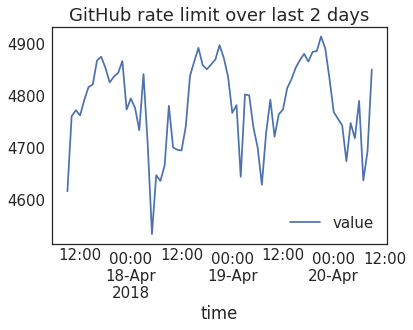

In [5]:
ax = all_data.plot()
ax.set(title="GitHub rate limit over last 2 days");

# Container names
Query containers deployed in the last N days.

In [6]:
n_days = 2
query = 'binderhub_launch_time_seconds_count{}{}'
query_days = "[{}d]".format(n_days)
query_selectors = "{status='success'}"
query = query.format(query_selectors, query_days)
resp = requests.get('https://prometheus.mybinder.org/api/v1/query', params={'query': query})
data = resp.json()['data']['result']

In [7]:
# Collect and count the data
df = {'name': [], 'org': [], 'provider': [], 'builds': []}
for container in data:
    if 'repo' not in container['metric']:
        continue
    pref, org, repo = container['metric']['repo'].rsplit('/', 2)
    provider = pref.replace('https://', '')
    counts = [int(ii[1]) for ii in container['values']]
    builds = np.max(counts)
    df['name'].append(repo)
    df['org'].append(org)
    df['provider'].append(provider)
    df['builds'].append(builds)
df = pd.DataFrame(df)
df = df.drop_duplicates(['name'])
df = df.groupby(['name', 'org', 'provider']).sum().reset_index().sort_values('builds', ascending=False)
df['log_builds'] = df['builds'].apply(np.log)

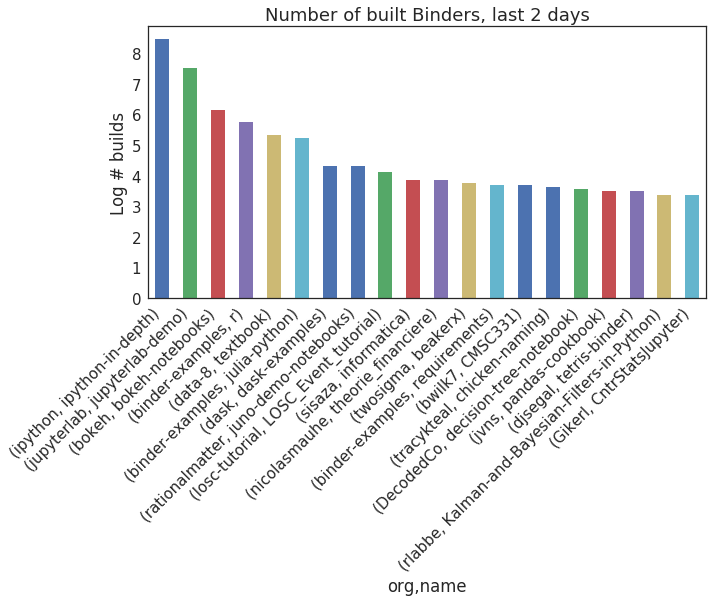

In [12]:
ax = df.head(20).plot.bar(['org', 'name'], y='log_builds', figsize=(10, 5))
ax.set(title="Number of built Binders, last {} days".format(n_days),
       ylabel='Log # builds')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.setp(ax.legend_, visible=False);